# 0. 버전확인

In [1]:
import tensorflow

print(tensorflow.__version__)

2.6.0


# Step 1. 데이터 수집하기
### 한국어 챗봇 데이터는 tunib에서 제공하는 데이터셋으로, 멀티턴 대화 형식의 데이터로 구성

Cloud shell에서 아래 명령어를 입력해 주세요.

$ mkdir -p ~/aiffel/dktc
$ ln -s ~/data/ ~/aiffel/dktc

# Step 2. 데이터 전처리하기
### 영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

=3


In [3]:
train_data_path ="aiffel/dktc/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [4]:
data = train_data

In [5]:
num_samples = len(data)
print("샘플 개수:", num_samples)

샘플 개수: 12092


In [6]:
# 중복 확인
from collections import Counter

data_counts = Counter(data)
duplicates = {item: count for item, count in data_counts.items() if count > 1}

print("중복된 데이터:", duplicates)  # {1: 2} (1이 2번 등장)

중복된 데이터: {}


In [7]:
# 'class' 열과 'idx' 열에 누락값 확인
missing_class = data['class'].isnull().any()
missing_idx = data['idx'].isnull().any()

print("class 열에 누락값이 있습니까?", missing_class)  # True (누락값 있음)
print("idx 열에 누락값이 있습니까?", missing_idx)      # True (누락값 있음)


class 열에 누락값이 있습니까? False
idx 열에 누락값이 있습니까? False


In [8]:
import re

# 한글 불용어 목록
stopwords = [
    "이", "그", "저", "가", "을", "를", "에", "의", "와", "과", "들"
]

def preprocess_korean_text(data):
    processed_texts = []
    
    for sentence in data:
        # 구두점 처리
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        
        # 중복 공백 제거
        sentence = re.sub(r'\s+', ' ', sentence)
        
        # 양쪽 공백 제거
        sentence = sentence.strip()
        
        processed_texts.append(sentence)
    
    return processed_texts

def remove_stopwords(data, stopwords):
    filtered_texts = []
    
    for sentence in data:
        # 텍스트를 공백으로 분리하여 단어 리스트 생성
        words = sentence.split()
        
        # 불용어가 아닌 단어만 필터링
        filtered_words = [word for word in words if word not in stopwords]
        
        # 필터링된 단어를 다시 문자열로 결합
        filtered_texts.append(' '.join(filtered_words))
    
    return filtered_texts


# conversation 열에 대해서만 전처리 및 불용어 제거 적용
data['conversation_processed'] = preprocess_korean_text(data['conversation'])
data['conversation_filtered'] = remove_stopwords(data['conversation_processed'], stopwords)

# 결과 확인
print(data[['conversation', 'conversation_processed', 'conversation_filtered']].head())


                                        conversation  \
0  지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...   
1  길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...   
2  너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...   
3  어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...   
4  저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...   

                              conversation_processed  \
0  지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...   
1  길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...   
2  너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...   
3  어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...   
4  저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 이 선크림 파는데 한 번 손등에...   

                               conversation_filtered  
0  지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...  
1  길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...  
2  너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...  
3  어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...  
4  저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 선크림 파는데 한 번 손등에 발..

In [9]:
data

,idx,class,conversation,conversation_processed,conversation_filtered
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...,길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...,어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 이 선크림 파는데 한 번 손등에...,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 선크림 파는데 한 번 손등에 발...
...,...,...,...,...,...
12087,12087,일반,미안하다... 나 내일 회사 하루 쉬려고. 회사를? 어...너무 힘들어서 하루 쉬고...,미안하다 . . . 나 내일 회사 하루 쉬려고 . 회사를 ? 어 . . . 너무 힘...,미안하다 . . . 나 내일 회사 하루 쉬려고 . 회사를 ? 어 . . . 너무 힘...
12088,12088,일반,아~엄마 뭐하는데 이 오밤중에? 난 정말 나간다. 애들처럼 왜 이러냐고? 동네 창피...,아~엄마 뭐하는데 이 오밤중에 ? 난 정말 나간다 . 애들처럼 왜 이러냐고 ? 동네...,아~엄마 뭐하는데 오밤중에 ? 난 정말 나간다 . 애들처럼 왜 이러냐고 ? 동네 창...
12089,12089,일반,"니 방에 들어가, 자 임마. 엄마 갑자기 짐 들고 사라질까봐 불안해서 못 나가. 겁...","니 방에 들어가 , 자 임마 . 엄마 갑자기 짐 들고 사라질까봐 불안해서 못 나가 ...","니 방에 들어가 , 자 임마 . 엄마 갑자기 짐 들고 사라질까봐 불안해서 못 나가 ..."
12090,12090,일반,"어, 왜 일어나있어? 힘든데 누워있지. 아니, 이젠 괜찮아 오빠. 뭐가 괜찮아? 어...","어 , 왜 일어나있어 ? 힘든데 누워있지 . 아니 , 이젠 괜찮아 오빠 . 뭐가 괜...","어 , 왜 일어나있어 ? 힘든데 누워있지 . 아니 , 이젠 괜찮아 오빠 . 뭐가 괜..."


In [10]:
# Q열과 A열 삭제
data = data.drop(columns=['conversation', 'conversation_processed'])
data

,idx,class,conversation_filtered
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...
1,1,협박 대화,길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...
3,3,갈취 대화,어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 선크림 파는데 한 번 손등에 발...
...,...,...,...
12087,12087,일반,미안하다 . . . 나 내일 회사 하루 쉬려고 . 회사를 ? 어 . . . 너무 힘...
12088,12088,일반,아~엄마 뭐하는데 오밤중에 ? 난 정말 나간다 . 애들처럼 왜 이러냐고 ? 동네 창...
12089,12089,일반,"니 방에 들어가 , 자 임마 . 엄마 갑자기 짐 들고 사라질까봐 불안해서 못 나가 ..."
12090,12090,일반,"어 , 왜 일어나있어 ? 힘든데 누워있지 . 아니 , 이젠 괜찮아 오빠 . 뭐가 괜..."


In [11]:
# 열 이름 변경
data = data.rename(columns={'conversation_filtered': 'conversation'})
data


,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...
1,1,협박 대화,길동경찰서입니다 . 9시 40분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...
3,3,갈취 대화,어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 선크림 파는데 한 번 손등에 발...
...,...,...,...
12087,12087,일반,미안하다 . . . 나 내일 회사 하루 쉬려고 . 회사를 ? 어 . . . 너무 힘...
12088,12088,일반,아~엄마 뭐하는데 오밤중에 ? 난 정말 나간다 . 애들처럼 왜 이러냐고 ? 동네 창...
12089,12089,일반,"니 방에 들어가 , 자 임마 . 엄마 갑자기 짐 들고 사라질까봐 불안해서 못 나가 ..."
12090,12090,일반,"어 , 왜 일어나있어 ? 힘든데 누워있지 . 아니 , 이젠 괜찮아 오빠 . 뭐가 괜..."


# Step 3. SubwordTextEncoder 사용하기
### 한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용

#### 1. 단어장(Vocabulary) 만들기

In [12]:
import tensorflow_datasets as tfds

# 열 이름 변경
data = data.rename(columns={'class': 'class_label'})

# 데이터프레임에서 questions와 answers 열을 리스트로 변환
conversation = data['conversation'].tolist()
class_label = data['class_label'].tolist()

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(conversation + class_label, target_vocab_size=2**14)

# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

16144


#### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

In [13]:
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(conversation[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(class_label[21])))


정수 인코딩 후의 21번째 질문 샘플: [9, 579, 456, 4801, 150, 64, 12602, 127, 1, 6755, 28, 17, 31, 1560, 1, 25, 18, 12091, 15387, 207, 537, 137, 2674, 1, 7, 17, 6121, 872, 2, 18, 12091, 4923, 2020, 2, 68, 9565, 15918, 64, 8367, 164, 1487, 2443, 3358, 2, 1119, 37, 872, 2, 11394, 11610, 1, 25, 31, 9579, 120, 1, 833, 12091, 5675, 1462, 2, 860, 617, 5]
정수 인코딩 후의 21번째 답변 샘플: [87, 13]


대화의 최소 길이 : 8
대화의 최대 길이 : 305
대화의 평균 길이 : 55.55946080052927


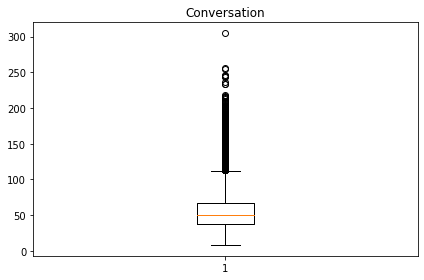

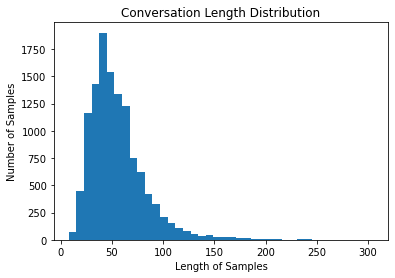

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 길이 분포 출력
conversation_len = [len(s.split()) for s in data['conversation']]
class_label_len = [len(s.split()) for s in data['class_label']]

print('대화의 최소 길이 : {}'.format(np.min(conversation_len)))
print('대화의 최대 길이 : {}'.format(np.max(conversation_len)))
print('대화의 평균 길이 : {}'.format(np.mean(conversation_len)))

# 길이 분포 시각화
plt.subplot(1, 1, 1)
plt.boxplot(conversation_len)
plt.title('Conversation')

plt.tight_layout()
plt.show()

plt.title('Conversation Length Distribution')
plt.hist(conversation_len, bins=40)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()


In [15]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 120
print(MAX_LENGTH)

120


In [16]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 140 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 140으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

# 정수 인코딩 과정을 수행하면서 샘플의 길이가 140을 넘는 경우는 샘플들을 필터링함. 단어장의 크기와 샘플의 개수를 확인
import tensorflow as tf
conversation, class_label = tokenize_and_filter(conversation, class_label)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 대화 샘플 개수: {}'.format(len(conversation)))

단어장의 크기 : 16144
필터링 후의 대화 샘플 개수: 11062


In [17]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': conversation,
        'dec_inputs': class_label[:, :-1]
    },
    {
        'outputs': class_label[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# step 4. 모델 정의

#### 9-4. 트랜스포머의 입력 이해하기_포지셔널 인코딩 레이어

In [18]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


#### 9-6. 스케일드 닷 프로덕트 어텐션

In [19]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


#### 9-7. 머리가 여러 개인 어텐션_멀티 헤드 어텐션 

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)  # Dense를 적용
    key = self.key_dense(key)        # Dense를 적용
    value = self.value_dense(value)  # Dense를 적용
    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)  # 머리 분리
    key = self.split_heads(key, batch_size)        # 머리 분리
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


#### 9-8. 마스킹

In [21]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [22]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


#### 9-9. 인코더

In [23]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [24]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### 9-10. 디코더

In [25]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [26]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

# step 5. 트랜스포머 구현

In [27]:
target_vocab_size = 2**14

def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=target_vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


# step 6. 모델 학습

In [28]:
# 모델 정의

In [29]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.05 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    5187072     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [30]:
# 손실함수 정의

In [31]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


In [32]:
# 커스텀 된 학습률

In [33]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


In [34]:
# 모델 컴파일

In [35]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [36]:
# 훈련

In [37]:
EPOCHS = 9
history = model.fit(dataset, epochs=EPOCHS, verbose=1)


Epoch 1/9
173/173 [==============================] - 37s 180ms/step - loss: 0.1746 - accuracy: 0.0087
Epoch 2/9
173/173 [==============================] - 32s 184ms/step - loss: 0.0884 - accuracy: 0.0175
Epoch 3/9
173/173 [==============================] - 33s 189ms/step - loss: 0.0149 - accuracy: 0.0191
Epoch 4/9
173/173 [==============================] - 33s 191ms/step - loss: 0.0038 - accuracy: 0.0202
Epoch 5/9
173/173 [==============================] - 33s 189ms/step - loss: 0.0012 - accuracy: 0.0209
Epoch 6/9
173/173 [==============================] - 33s 190ms/step - loss: 4.1086e-04 - accuracy: 0.0211
Epoch 7/9
173/173 [==============================] - 33s 190ms/step - loss: 2.9204e-04 - accuracy: 0.0211
Epoch 8/9
173/173 [==============================] - 33s 190ms/step - loss: 2.4561e-04 - accuracy: 0.0211
Epoch 9/9
173/173 [==============================] - 33s 190ms/step - loss: 1.5004e-04 - accuracy: 0.0212


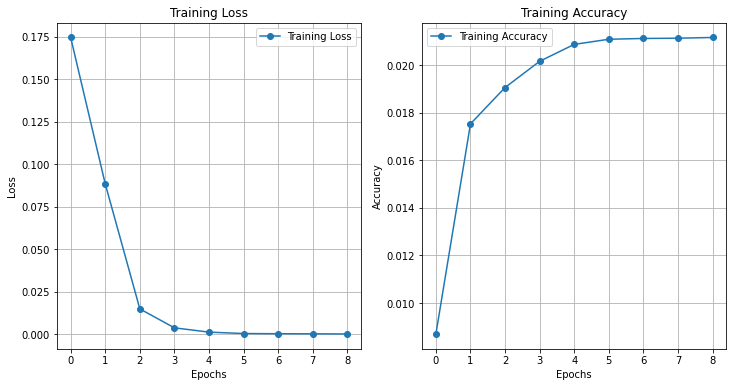

In [38]:
# 손실 값 그래프
plt.figure(figsize=(12, 6))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [39]:
test_data_path ="aiffel/dktc/test.csv"
test_data = pd.read_csv(test_data_path)
test_data.head()

,idx,text
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
1,t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...


In [40]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [41]:
output = predict('아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나보네 그럼 취소할까요 아가씨 내 여기단골이니 담에 갖다줄께 저도 알바생이라 외상안됩니다 아따 누가 떼먹는다고 그러나 갖다준다고 안됩니다 자꾸이럼 경찰불러요 아가씨 담배피는교 그건 왜 물으세요 그람 아가씨 담배 한대만 빌립시다 내 지금 지갑도 잃어버리고 기분이 그래서 그러니 여기요  아따 주는김에 한개더 주면 되겠네')

Input: 아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나보네 그럼 취소할까요 아가씨 내 여기단골이니 담에 갖다줄께 저도 알바생이라 외상안됩니다 아따 누가 떼먹는다고 그러나 갖다준다고 안됩니다 자꾸이럼 경찰불러요 아가씨 담배피는교 그건 왜 물으세요 그람 아가씨 담배 한대만 빌립시다 내 지금 지갑도 잃어버리고 기분이 그래서 그러니 여기요  아따 주는김에 한개더 주면 되겠네
Output: 갈취 대화


In [42]:
output = predict('우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때?  네? 제가요? 그렇지? 2달만 파견 잘 갔다오면 승진이야. 네? 저는 별로 가고 싶지 않습니다. 여기 있는 모든사람도 가기 싫어해. 그러니까 막내인 영지씨가 가는게 맞지 정말 죄송합니다. 저는 못갑니다. 장난해? 모두를 위해 영지씨가 희생하는게 싫어? 네. 부당한 방법으로 가는 것 같습니다. 영지씨 안가면 회사생활 오래 못할 것 같은데 그래도 안갈거야? 안가면 지옥일텐데. 그래도 이 방법은 아닌 것 같습니다. 죄송합니다.')

Input: 우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때?  네? 제가요? 그렇지? 2달만 파견 잘 갔다오면 승진이야. 네? 저는 별로 가고 싶지 않습니다. 여기 있는 모든사람도 가기 싫어해. 그러니까 막내인 영지씨가 가는게 맞지 정말 죄송합니다. 저는 못갑니다. 장난해? 모두를 위해 영지씨가 희생하는게 싫어? 네. 부당한 방법으로 가는 것 같습니다. 영지씨 안가면 회사생활 오래 못할 것 같은데 그래도 안갈거야? 안가면 지옥일텐데. 그래도 이 방법은 아닌 것 같습니다. 죄송합니다.
Output: 직장 내 괴롭힘 대화


In [43]:
output = predict('너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 행실이 맘에 안들어 네 실천할께요 옆에 동기들 좀 본받으란 말야 어? 네 알겠습니다 그래 똑바로해 노럭할께요')

Input: 너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 행실이 맘에 안들어 네 실천할께요 옆에 동기들 좀 본받으란 말야 어? 네 알겠습니다 그래 똑바로해 노럭할께요
Output: 직장 내 괴롭힘 대화


In [44]:
output = predict('그러니까 빨리 말해. 선생님 제발 살려주십시오.  비밀번호 틀릴 때마다 손톱 하나씩 뺀찌로 뽑는다.  선생님 저도 정말 모릅니다.  하나 엄지 손톱 뽑는다.  으악! 잘못했습니다. 그런데 진짜 모릅니다.  둘 이번에는 두 번째 손톱 뽑는다.  으악! 진짜 저는 모릅니다.  셋 중지를 아주 분질러 줄까?  으아아 살려주십시오.  아니다 아주 손가락을 다 잘라놔야겠다.')

Input: 그러니까 빨리 말해. 선생님 제발 살려주십시오.  비밀번호 틀릴 때마다 손톱 하나씩 뺀찌로 뽑는다.  선생님 저도 정말 모릅니다.  하나 엄지 손톱 뽑는다.  으악! 잘못했습니다. 그런데 진짜 모릅니다.  둘 이번에는 두 번째 손톱 뽑는다.  으악! 진짜 저는 모릅니다.  셋 중지를 아주 분질러 줄까?  으아아 살려주십시오.  아니다 아주 손가락을 다 잘라놔야겠다.
Output: 협박 대화


In [45]:
output = predict('야 너 2학년 김민석 맞지? 네 맞는데요. 혹시 누구신가요? 내가 누군지 궁금하면 학교 뒤쪽으로 내려와. 2분 준다. 네 지금 내려가겠습니다. 야 니가 김민석이냐? 돈 있어? 돈 없는데요. 야 쟤 몸뒤져. 너 천 원 나올 때마다 얼차려 10분이다. 야 여기 얘 지갑 있는데? 오 지갑만 봐도 돈 많게 생겼네. 열어봐봐 오 12만원 있네? 얼차려가 몇 분이야? 야 이 돈 주면 얼차려 없애줄게. 그거 오늘 저 문제집 사려고 가져온 돈이라. 혹시 내일 드리면 안될까요? 야 니 얼차려 받고 싶냐? 그렇게 내일 주고 싶으면 오늘 이 돈도 우리 주고 내일도 돈 가져다 주면 돼. 뭐가 어려워. 네 알겠습니다. 그 12만원 가져게세요. 말 잘 듣네. 아주 예뻐 내일도 돈 가져와라. 안 그러면 알지? 내일도 같은 시간에 여기로 와.')

Input: 야 너 2학년 김민석 맞지? 네 맞는데요. 혹시 누구신가요? 내가 누군지 궁금하면 학교 뒤쪽으로 내려와. 2분 준다. 네 지금 내려가겠습니다. 야 니가 김민석이냐? 돈 있어? 돈 없는데요. 야 쟤 몸뒤져. 너 천 원 나올 때마다 얼차려 10분이다. 야 여기 얘 지갑 있는데? 오 지갑만 봐도 돈 많게 생겼네. 열어봐봐 오 12만원 있네? 얼차려가 몇 분이야? 야 이 돈 주면 얼차려 없애줄게. 그거 오늘 저 문제집 사려고 가져온 돈이라. 혹시 내일 드리면 안될까요? 야 니 얼차려 받고 싶냐? 그렇게 내일 주고 싶으면 오늘 이 돈도 우리 주고 내일도 돈 가져다 주면 돼. 뭐가 어려워. 네 알겠습니다. 그 12만원 가져게세요. 말 잘 듣네. 아주 예뻐 내일도 돈 가져와라. 안 그러면 알지? 내일도 같은 시간에 여기로 와.
Output: 갈취 대화


In [46]:
output = predict('김인턴 지금 회의 들어가야 되니까 빨리 이거 좀 해와. 아 저 지금 퇴근하려고 했는데요 야 김인턴. 너 정규직 되기 싫어? 아뇨 되고 싶습니다 근데 행동거지가 그따구야? 죄송합니다 너 전환되는거 내 입김 쎈거 몰라서 지금 말대꾸야? 빨리 해와 알았어? 알겠습니다 너 한 번만 더 그래봐 진짜. 죄송합니다.')

Input: 김인턴 지금 회의 들어가야 되니까 빨리 이거 좀 해와. 아 저 지금 퇴근하려고 했는데요 야 김인턴. 너 정규직 되기 싫어? 아뇨 되고 싶습니다 근데 행동거지가 그따구야? 죄송합니다 너 전환되는거 내 입김 쎈거 몰라서 지금 말대꾸야? 빨리 해와 알았어? 알겠습니다 너 한 번만 더 그래봐 진짜. 죄송합니다.
Output: 직장 내 괴롭힘 대화


In [47]:
output = predict('안녕하세요 저는 이번에 새로온 알바생입니다 반가워요 서브웨이 알바는 처음이죠 네 빵집 아르바이트는 해봤는데 서브웨이는 처음이네요 별거 없고 비슷해요 포스는 해봤어요 네 많이 해봤어요 그러면 빵 종류랑 레시피만 설명드릴게요 감사합니다 혹시 메일주소 알려줄래요 레시피 보내드릴게요 문자로 보내드릴게요 고마워요 네 잘 부탁드려요')

Input: 안녕하세요 저는 이번에 새로온 알바생입니다 반가워요 서브웨이 알바는 처음이죠 네 빵집 아르바이트는 해봤는데 서브웨이는 처음이네요 별거 없고 비슷해요 포스는 해봤어요 네 많이 해봤어요 그러면 빵 종류랑 레시피만 설명드릴게요 감사합니다 혹시 메일주소 알려줄래요 레시피 보내드릴게요 문자로 보내드릴게요 고마워요 네 잘 부탁드려요
Output: 직장 내 괴롭힘 대화


In [48]:
output = predict('흑흑 나 도저히 못찾아 찾아줘 거봐 디자이너들이 생각이없다니까 중국인들이 최고야 중국인좀데려다가 좋은원단으로좀 만들어주지 엠제이드사지마 물론돈없어아직 웅사지마 가방필요한데어떡해 잘좀찾아보 정말없지만 찾고말겠어 말일까지 찾아 없지만 퉁')

Input: 흑흑 나 도저히 못찾아 찾아줘 거봐 디자이너들이 생각이없다니까 중국인들이 최고야 중국인좀데려다가 좋은원단으로좀 만들어주지 엠제이드사지마 물론돈없어아직 웅사지마 가방필요한데어떡해 잘좀찾아보 정말없지만 찾고말겠어 말일까지 찾아 없지만 퉁
Output: 직장 내 괴롭힘 대화


In [49]:
output = predict('빠끄 뭐해 빠끄빠끄 거려 염따형 모르냐 몰라 그게 누군데 랩퍼이자 유튜버 재밌어 관심없다 빠끄 아 제발 알았어 안할게 빠끄 꺼져 쫌')

Input: 빠끄 뭐해 빠끄빠끄 거려 염따형 모르냐 몰라 그게 누군데 랩퍼이자 유튜버 재밌어 관심없다 빠끄 아 제발 알았어 안할게 빠끄 꺼져 쫌
Output: 직장 내 괴롭힘 대화


#### 위에건 일반 대화 아닌가? 애매함ㅎ. 2 epochs에서는 일반 대화로 분류함

In [50]:
output = predict('국희씨 네? 이번주말에 뭐해? 애들이랑 키즈카페 가기러했어요 어 사실 나도 아까 점심먹을때 들어서 알고 있었는데 확인차 물어봤어 왜그러세요? 응 우리애들이랑 국희씨 애들이랑 나이도 얼추 비슷한데 주말에 키즈카페 좀 데려가주라 네?? 실장님은 안가시구요? 어 나는 집도 좀 치우고 밀린 일좀 보게 부탁할게 하지만 제가 애들 4명이나 보기엔 우리애들 얌전하니까 너무걱정마 내가 주의줄게 그럼 주말에 우리집앞으로 와')

Input: 국희씨 네? 이번주말에 뭐해? 애들이랑 키즈카페 가기러했어요 어 사실 나도 아까 점심먹을때 들어서 알고 있었는데 확인차 물어봤어 왜그러세요? 응 우리애들이랑 국희씨 애들이랑 나이도 얼추 비슷한데 주말에 키즈카페 좀 데려가주라 네?? 실장님은 안가시구요? 어 나는 집도 좀 치우고 밀린 일좀 보게 부탁할게 하지만 제가 애들 4명이나 보기엔 우리애들 얌전하니까 너무걱정마 내가 주의줄게 그럼 주말에 우리집앞으로 와
Output: 직장 내 괴롭힘 대화


In [51]:
output = predict('저기요 제가 파워블로거에 맘카페까지 활동하고 있어요.  아.네. 멋지시네요!!!! 파워블로거 분들이 쓰신글을 조금 믿음이 가더라구요. 그쵸? 와 된장찌개 진짜 잘 먹었어요. 요리 솜씨가 좋네요 이만 가보겠습니다. 저기요 손님 밥 값 지불 안 하셨는데요! 네? 저 파워블로거라니까요? 제가 홍보해드릴건데 밥은 무료로 주셔야죠 저 홍보해달라고 한 적 없는데요 와서 빨리 밥값내고 가세요. 저 홍보해달라고 한 적 없어요. 그렇게 말 번복하시면 안되죠. 엄연한 계약 사항인데. 제가 언제리뷰해달라고 했어요 그냥 멋지시다고 했죠 빨리 돈내고 가세요. 나참 어이가 없네 아주 안 좋게 적을거니까 각오하세요. 하. 그냥 돈 내지말고 가세요. 그냥 가셔도 됩니다.')

Input: 저기요 제가 파워블로거에 맘카페까지 활동하고 있어요.  아.네. 멋지시네요!!!! 파워블로거 분들이 쓰신글을 조금 믿음이 가더라구요. 그쵸? 와 된장찌개 진짜 잘 먹었어요. 요리 솜씨가 좋네요 이만 가보겠습니다. 저기요 손님 밥 값 지불 안 하셨는데요! 네? 저 파워블로거라니까요? 제가 홍보해드릴건데 밥은 무료로 주셔야죠 저 홍보해달라고 한 적 없는데요 와서 빨리 밥값내고 가세요. 저 홍보해달라고 한 적 없어요. 그렇게 말 번복하시면 안되죠. 엄연한 계약 사항인데. 제가 언제리뷰해달라고 했어요 그냥 멋지시다고 했죠 빨리 돈내고 가세요. 나참 어이가 없네 아주 안 좋게 적을거니까 각오하세요. 하. 그냥 돈 내지말고 가세요. 그냥 가셔도 됩니다.
Output: 직장 내 괴롭힘 대화


# 하이퍼파라미터 간 실험

### 1. Max length값 120->100 감소 시키기

In [55]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 100

BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': conversation,
        'dec_inputs': class_label[:, :-1]
    },
    {
        'outputs': class_label[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [56]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.05 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

epochs = 9


# epochs를 9으로 설정하고 모델을 학습합니다.
history = model.fit(dataset, epochs=epochs, verbose=1)

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    5187072     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /tmp/ipykernel_347/3646571114.py:8 accuracy  *
        return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/metrics.py:3537 sparse_categorical_accuracy
        return tf.cast(tf.equal(y_true, y_pred), backend.floatx())
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1864 equal
        return gen_math_ops.equal(x, y, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/gen_math_ops.py:3217 equal
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:3561 _create_op_internal
        ret = Operation(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 99 and 119 for '{{node Equal}} = Equal[T=DT_FLOAT, incompatible_shape_error=true](Reshape, Cast_2)' with input shapes: [?,99], [?,119].


In [ ]:
# 손실 값 그래프
plt.figure(figsize=(12, 6))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# 회고
[Positional Encoding]
positional encoding을 gpt-1처럼 embedding으로 변경하면 어떻게 될까?
transformer에서 주로 positional encoding보다 embedding이 더 성능이 잘 나올 것 같은데(단어 간의 의미 관계를 유의미한 벡터의 거리로 표현했기 때문) encoding이 주로 사용되는 이유가 embedding보다 데이터 소모 가성비가 좋아서일까?

[토크나이징 - 형태소 분석기/subwordtovector]
한국어 데이터에 주로 사용되는 형태소 분석기를 사용하여 토크나이징을 하면 성능이 어떻게 될까?

[Max length값]
사분위 값인 120을 기준으로 100 or 140 에서의 성능?

[dropout 값]
0.01 -> (0.05) -> 0.10 비교

[batch size와 buffer size]
1) epochs 수와 batch size의 관계?
2) batch size와 buffer size의 관계?

[epochs]
early stopping을 통해 최적의 epochs 수 확인

[Num_LAYERS] 
인코더와 디코더의 층의 개수를 증가시킨다면?
(2) -> 4 -> 8 -> 12

[실험 수업 때 했던 파라미터 최적화 기능?]
위 기능을 사용하면 여러번 실험을 하지 않아도 파라미터 별 영향도 및 최적값을 도출해줄까? 시간을 아낄 수 있을 것 같다
